### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Importing DataSet and Pre-Procesisng Test Dataset

In [2]:
# Load the MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="/cnn_data", train=True, download=True, transform=transform) # Train = True
test_data = datasets.MNIST(root="/cnn_data", train=False, download=True, transform=transform) # Train = False

# Training and Testing Dataset element comes in tuple form. Will change 2nd element in tuple to rotated image.
# Create a new train dataset
new_train_data = []
for i in range(len(train_data)):
    image, label = train_data[i]
    rotated_image = torch.rot90(image[0], 1) # Does rotation of image matter? This line rotates the images counter-clockise.
    new_train_data.append((image, rotated_image))

# Create a new test dataset
new_test_data = []
for i in range(len(test_data)):
    image, label = test_data[i]
    rotated_image = torch.rot90(image[0], 1)
    new_test_data.append((image, rotated_image))

# replacing given train and test dataset images to save RAM
train_data = new_train_data
del new_train_data

test_data = new_test_data
del new_test_data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37778002.03it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1144279.29it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9987308.29it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1523189.32it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



Text(0.5, 1.0, 'Train Data - 90 Degree Rotated Image')

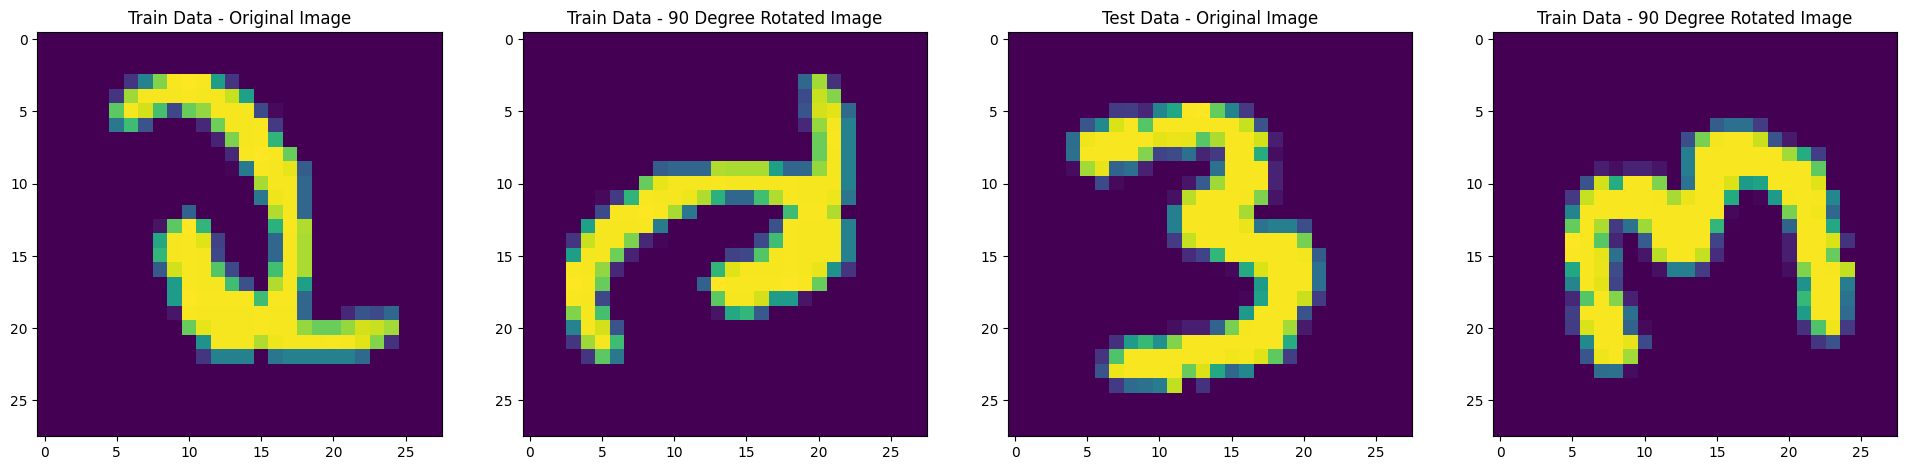

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(24, 12))

# Training Data OG Image
ax[0].imshow(train_data[400][0].reshape(28,28))
ax[0].set_title('Train Data - Original Image')

# Training Data Rotated Image
ax[1].imshow(train_data[400][1].reshape(28,28))
ax[1].set_title('Train Data - 90 Degree Rotated Image')

# Testing Data OG Image
ax[2].imshow(test_data[500][0].reshape(28,28))
ax[2].set_title('Test Data - Original Image')

# Testing Data Rotated Image
ax[3].imshow(test_data[500][1].reshape(28,28))
ax[3].set_title('Train Data - 90 Degree Rotated Image')

In [4]:
print("Train Dataset:", len(train_data), " images.")
print("Test Dataset:", len(test_data), " images.")

Train Dataset: 60000  images.
Test Dataset: 10000  images.


### Trial #2: Y-Shaped Autoencoder

In [9]:
torch.manual_seed(4)

In [10]:
# Creating Autoencoder
class Autoencoder_CONV(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # 16 outputs. 14 X 14 Pixels
        nn.ReLU(), # Chose ReLU as activation function but will test others when hyperparameter tuning
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32 outputs 7 X 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # 64 Outputs/Channels 1 X 1 Pixels
    )

    # decoder 1 for image reconstruction
    self.decoder1 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

    # decoder 2 for rotation
    self.decoder2 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded1 =  self.decoder1(encoded)
    decoded2 = self.decoder2(encoded)
    return decoded1 , decoded2

# Will later play with Pooling Techniques to further downsize parameter space and increase computation time
# Suggestion: nn.MaxPool2d and nn.MaxUnpool2d

In [11]:
model = Autoencoder_CONV()
criterion = nn.MSELoss() # Chose Mean Squared Error as loss function because common for regression problems
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# For this problem, I utilized Adam because in papers, it was found for regression problems, Adam converges faster than other optimizers. Also, Adam was developed for larger datasets

In [12]:
# NOTE: 3 epochs and 5000 images - 4 minutes
num_epochs = 4

outputs_train = [] #this will store the reconstructed and rotated images
outputs_val = []
train_loss = []
# val_loss = []

amount = 5000 #25000
# alpha = 0.005

# Training Loop
for epoch in range(num_epochs):
  train_avg, train1_avg, train2_avg = 0, 0, 0
  # val_avg, val1_avg, val2_avg = 0, 0, 0

  for img_pair in train_data[:amount]:
    img = img_pair[0] # .reshape(-1,28*28)
    r = model(img) # decoders return two images - reconstructed image and rotated image

    loss_1 = criterion(r[0],img_pair[0]) # reconstructed image loss
    loss_2 = criterion(r[1],img_pair[1]) # rotated image loss
    loss = loss_1 + loss_2 # loss = alpha*loss_1 + (1-alpha)*loss_2

    train_avg += loss
    train1_avg += loss_1
    train2_avg += loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # outputs_train.append((epoch, r[0], r[1])) # Storing Output Images Into A List
    # train_loss.append((epoch, loss, loss_1, loss_2 ))

    print(f'Epoch:{epoch+1}, Loss Train:{loss.item():.4f}, Loss 1 Train:{loss_1.item():.4f}, Loss 2 Train:{loss_2.item():.4f}')

  train_loss.append((epoch, train_avg/amount, train1_avg/amount, train2_avg/amount))

Streaming output truncated to the last 5000 lines.
Epoch:4, Loss Train:0.0255, Loss 1 Train:0.0115, Loss 2 Train:0.0141
Epoch:4, Loss Train:0.0185, Loss 1 Train:0.0092, Loss 2 Train:0.0093
Epoch:4, Loss Train:0.0210, Loss 1 Train:0.0101, Loss 2 Train:0.0108
Epoch:4, Loss Train:0.0047, Loss 1 Train:0.0025, Loss 2 Train:0.0022
Epoch:4, Loss Train:0.0146, Loss 1 Train:0.0063, Loss 2 Train:0.0083
Epoch:4, Loss Train:0.0206, Loss 1 Train:0.0102, Loss 2 Train:0.0104
Epoch:4, Loss Train:0.0085, Loss 1 Train:0.0037, Loss 2 Train:0.0049
Epoch:4, Loss Train:0.0099, Loss 1 Train:0.0053, Loss 2 Train:0.0046
Epoch:4, Loss Train:0.0049, Loss 1 Train:0.0027, Loss 2 Train:0.0022
Epoch:4, Loss Train:0.0188, Loss 1 Train:0.0100, Loss 2 Train:0.0087
Epoch:4, Loss Train:0.0122, Loss 1 Train:0.0066, Loss 2 Train:0.0056
Epoch:4, Loss Train:0.0230, Loss 1 Train:0.0122, Loss 2 Train:0.0109
Epoch:4, Loss Train:0.0248, Loss 1 Train:0.0119, Loss 2 Train:0.0128
Epoch:4, Loss Train:0.0263, Loss 1 Train:0.0127, Los

In [13]:
# List of Training Loss Sum, Training Loss Reconstruction, Training Loss Rotation
t_loss = []
t_loss_1 = []
t_loss_2 = []
for i in train_loss:
  t_loss.append(i[1].detach().numpy())
  t_loss_1.append(i[2].detach().numpy())
  t_loss_2.append(i[3].detach().numpy())

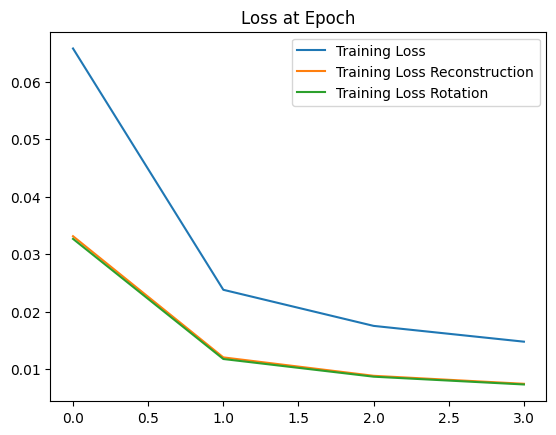

In [14]:
plt.plot(t_loss, label = "Training Loss")
plt.plot(t_loss_1, label = "Training Loss Reconstruction")
plt.plot(t_loss_2, label = "Training Loss Rotation")

plt.title("Loss at Epoch")
plt.legend()

#### Validation Test To Implement into Training and Testing Loop

    # Validation Loop
    for img_pair in test_data[:2000]:
      img = img_pair[0] # .reshape(-1,28*28)
      r = model(img) # decoders return two images - reconstructed image and rotated image

      loss_1 = criterion(r[0],img_pair[0]) # reconstructed image loss
      loss_2 = criterion(r[1],img_pair[1]) # rotated image loss
      loss = loss_1 + loss_2 # loss = alpha*loss_1 + (1-alpha)*loss_2

      # outputs_val.append((epoch,r[0],r[1]))  # Storing Output Images Into A List
      # val_loss.append((epoch, loss, loss_1, loss_2))
      print(f'Epoch:{epoch+1}, Loss Test:{loss.item():.4f}, Loss 1 Test:{loss_1.item():.4f}, Loss 2 Test:{loss_2.item():.4f}')

      val_avg += loss
      val1_avg += loss_1
      val2_avg += loss_2

    val_loss.append((epoch, val_avg/amount, val1_avg/amount, val2_avg/amount))

    # Grabbing Loss from Tensors
    v_loss = []
    v_loss_1 = []
    v_loss_2 = []
    for i in val_loss:
      v_loss.append(i[1].detach().numpy())
      v_loss_1.append(i[2].detach().numpy())
      v_loss_2.append(i[3].detach().numpy())

    # Plotting
    plt.plot(v_loss, label = "Validation Loss")
    plt.plot(v_loss_1, label = "Validation Loss Reconstruction")
    plt.plot(v_loss_2, label = "Validation Loss Rotation")

Text(0.5, 1.0, 'Train 90 Degree Rotated Img')

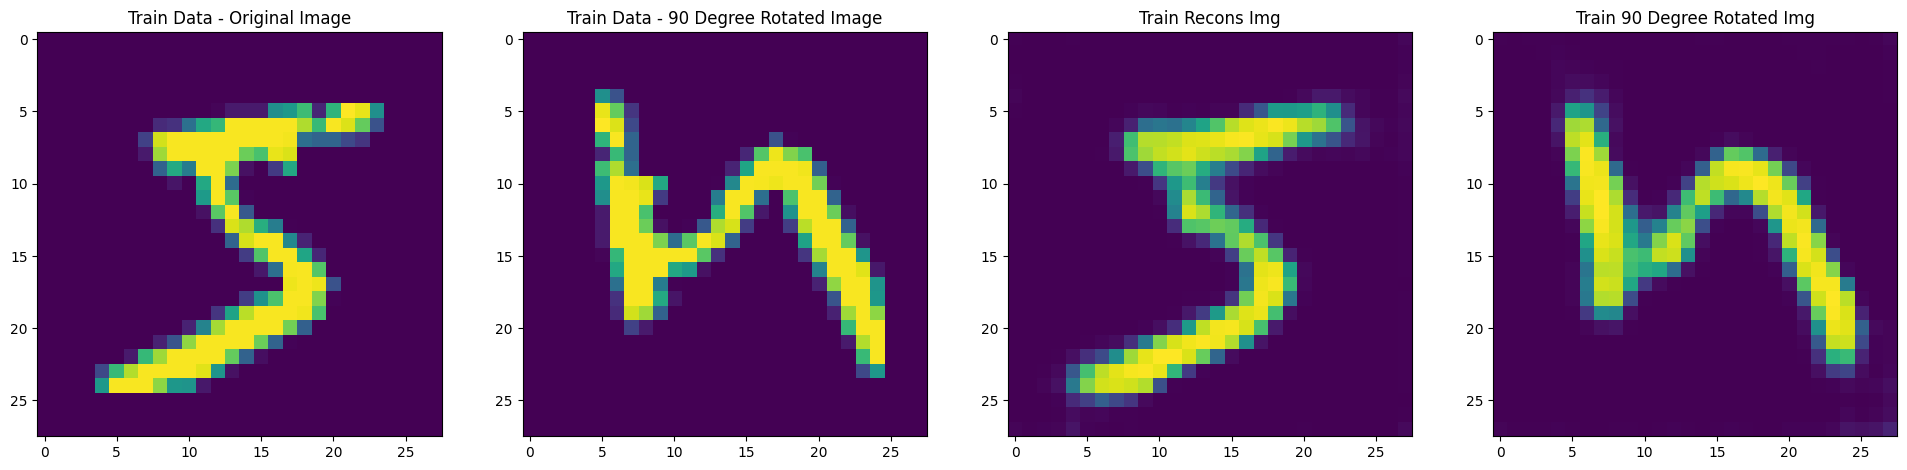

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(24, 12))

ax[0].imshow(train_data[0][0].reshape(28,28))
ax[0].set_title('Train Data - Original Image')

ax[1].imshow(train_data[0][1])
ax[1].set_title('Train Data - 90 Degree Rotated Image')

ax[2].imshow(model(train_data[0][0])[0].detach().numpy().reshape(28,28))
ax[2].set_title('Train Recons Img')

ax[3].imshow(model(train_data[0][0])[1].detach().numpy().reshape(28,28))
ax[3].set_title('Train 90 Degree Rotated Img')


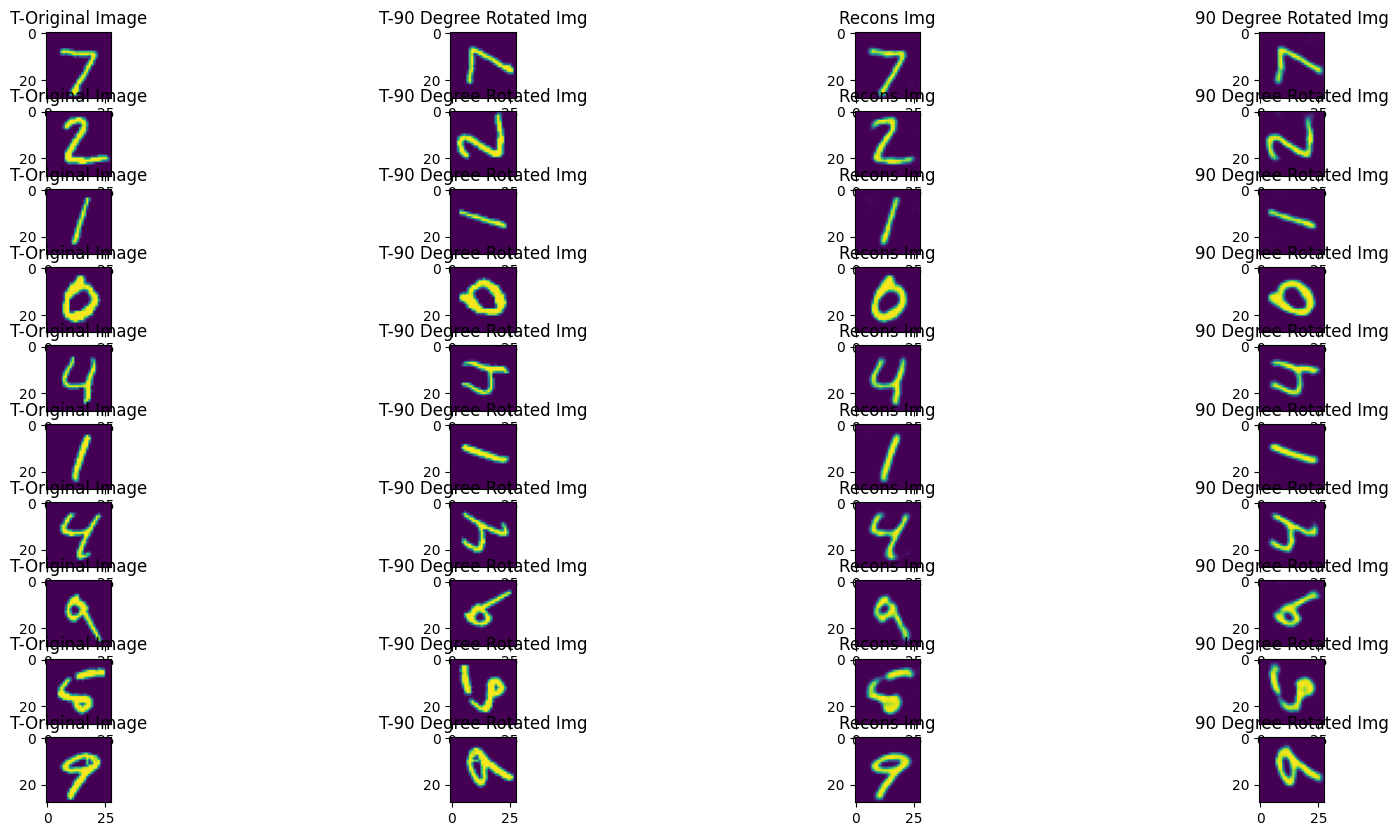

In [16]:
# Plotting Images
num_img = 10
row = 0
fig, ax = plt.subplots(num_img, 4, figsize=(20, 10))
for k in range(num_img):
  ax[row,0].imshow(test_data[k][0].reshape(28,28))
  ax[row,0].set_title('T-Original Image')

  ax[row,1].imshow(test_data[k][1])
  ax[row,1].set_title('T-90 Degree Rotated Img')

  ax[row,2].imshow(model(test_data[k][0])[0].detach().numpy().reshape(28,28))
  ax[row,2].set_title('Recons Img')

  ax[row,3].imshow(model(test_data[k][0])[1].detach().numpy().reshape(28,28))
  ax[row,3].set_title('90 Degree Rotated Img')

  row+=1

